## Определение критериев успешности игры
*(убрал подробности в целях соблюдения авторских прав)*

Нужно по таблице с информацией о продажах игр определить признаки хорошо продаваемых наименований.
Данные за 2016 год могут быть неполными.

### Шаг 1. Ознакомление с данными

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# предварительный просмотр структуры хранения данных, разделителей
!head /datasets/games.csv

In [3]:
#  разделитель - запятые
data = pd.read_csv('/datasets/games.csv', sep=',')

In [4]:
# просмотр загруженных данных
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [5]:
# есть ненулевые данные, посмотрим подробнее
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
# процент Null'ов по столбцам:
data.isnull().sum() / data.shape[0] * 100

Name                0.011965
Platform            0.000000
Year_of_Release     1.609333
Genre               0.011965
NA_sales            0.000000
EU_sales            0.000000
JP_sales            0.000000
Other_sales         0.000000
Critic_Score       51.319174
User_Score         40.089740
Rating             40.478612
dtype: float64

**Вывод:** Выявленные проблемы:
- Верхний регистр в названии столбцов
- Есть пропуски в 1,6 % данных касаемо года, это небольшой объем данных, кроме того, год, это то, на что мы не можем повлиять в плане определения критерия успешности. Поэтому в будущем удалю эти данные.
- Имя - вообще штучные пропуски, удалю.
- Проблема с типом данных - год как float64, рейтинг пользователей как строка.

- Пропуски в оценках пользователей, критиков и рейтинга (40-50%) - наибольшая проблема. Попробую восстановить эти данные.

### Шаг 2. Предобработка

In [7]:
# преобразование столбцов к нижнему регистру
data.columns = data.columns.str.lower()

# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [8]:
# удаление строк с незначительными пропусками в названии игры и года выпуска:
data = data.query('year_of_release.notna() and name.notna()')

# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [9]:
# преобразование типов
# год
data.loc[:,'year_of_release'] = data['year_of_release'].astype('int', errors='ignore')
# Рейтинг пользователей - для хранения дробных значений
data.loc[:,'user_score'] = data['user_score'].astype('float32', errors='ignore').astype('Int64', errors='ignore')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


#### Анализ таблиц на артефакты

##### Название

In [11]:
data['name'].value_counts().head()
# несколько игр с одинаковыми названиями

Need for Speed: Most Wanted    12
FIFA 14                         9
LEGO Marvel Super Heroes        9
Ratatouille                     9
Cars                            8
Name: name, dtype: int64

In [12]:
# сколько таких игр?
names = data['name'].value_counts()
print('Процент игр с дублями названий: {:.2f}%'.format(len(names[names > 1]) / data.shape[0] * 100))

Процент игр с дублями названий: 16.71%


In [13]:
# Посмотрю, просто ли это совпадения:
names_top_list = names.head(10).index.tolist()
for name, group in data.query('name in @names_top_list').groupby('name'):
    print(name)
    print(group)
    print()

Angry Birds Star Wars
                        name platform  year_of_release     genre  na_sales  \
5431   Angry Birds Star Wars      3DS             2013  Strategy      0.15   
6047   Angry Birds Star Wars      PS3             2013  Strategy      0.10   
6217   Angry Birds Star Wars     X360             2013  Strategy      0.16   
6443   Angry Birds Star Wars      Wii             2013  Strategy      0.15   
7296   Angry Birds Star Wars      PS4             2013  Strategy      0.10   
8607   Angry Birds Star Wars     XOne             2013  Strategy      0.11   
10755  Angry Birds Star Wars     WiiU             2013  Strategy      0.05   
11339  Angry Birds Star Wars      PSV             2013  Strategy      0.03   

       eu_sales  jp_sales  other_sales  critic_score user_score rating  
5431       0.15       0.0         0.03           NaN          3      E  
6047       0.14       0.0         0.05          49.0        3.6      E  
6217       0.10       0.0         0.02          59.0    

In [14]:
# очевидно, игры просто для разных платформ.

# проверю на всякий случай, есть ли полные дубли для колонок Игра и Платформа:
data[data.duplicated(subset=['name', 'platform'], keep=False)].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T


In [15]:
# таких данных немного, кроме того, есть ещё различия по году. Удалю дубликаты:
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
name               16443 non-null object
platform           16443 non-null object
year_of_release    16443 non-null int64
genre              16443 non-null object
na_sales           16443 non-null float64
eu_sales           16443 non-null float64
jp_sales           16443 non-null float64
other_sales        16443 non-null float64
critic_score       7982 non-null float64
user_score         9838 non-null object
rating             9767 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


##### Платформа

In [16]:
data['platform'].value_counts()

PS2     2127
DS      2121
PS3     1305
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

##### Год выпуска игры

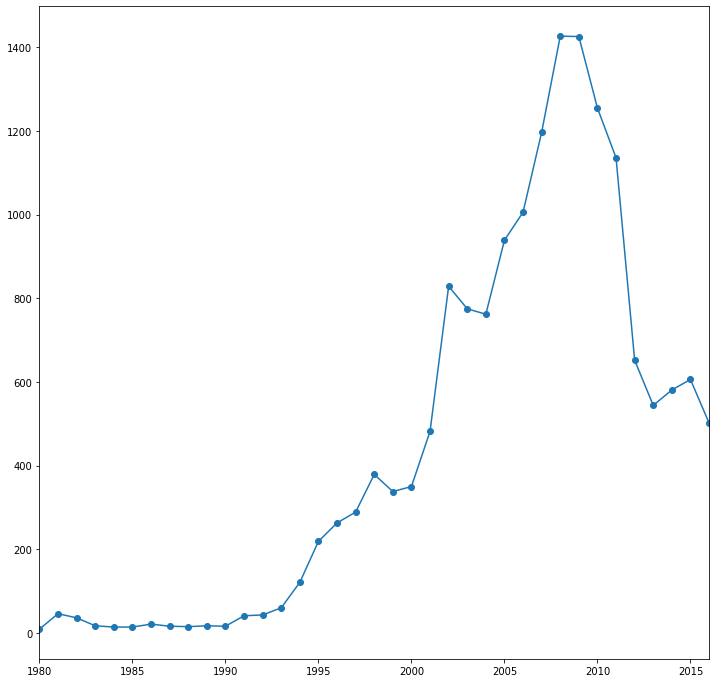

In [17]:
plt.figure(figsize=(12,12))
data['year_of_release'].value_counts().sort_index().plot(style='o-')
plt.show()
# корректные даты

##### Жанры

In [18]:
data['genre'].value_counts().to_frame().style.bar()
# корректно

,genre
Action,3307
Sports,2305
Misc,1721
Role-Playing,1481
Shooter,1296
Adventure,1293
Racing,1226
Platform,878
Simulation,857
Fighting,837


##### Столбцы по продажам

In [19]:
sales_columns = []
for column in data.columns:
    if 'sales' in column:
        sales_columns.append(column)
data[sales_columns].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16443.000000,16443.000000,16443.000000,16443.000000
mean,0.264028,0.145939,0.078492,0.047597
std,0.818400,0.506731,0.311109,0.188011
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


In [20]:
# замечены нулевые значения, посмотрим, сколько их
print('Нулевых значений продаж:')
for column in sales_columns:
    nole_count = data.query(column + ' == 0')[column].count()
    print('Для колонки ', column, ' - ', nole_count, ', в процентах: {:.2%}'.format(nole_count / data.shape[0]), sep='')

Нулевых значений продаж:
Для колонки na_sales - 4448, в процентах: 27.05%
Для колонки eu_sales - 5766, в процентах: 35.07%
Для колонки jp_sales - 10299, в процентах: 62.63%
Для колонки other_sales - 6491, в процентах: 39.48%


In [21]:
# Вот эти пропуски очень серьёзны... Посмотрим, какой процент данных о стоимости есть хотя бы по одному столбцу:
data_with_any_sales = data.query('na_sales != 0 or eu_sales != 0 or jp_sales != 0 or other_sales != 0')
print('Хотя бы по одному региону есть информация о цене у: {:.2%} данных'.format(data_with_any_sales.shape[0] / data.shape[0]))

Хотя бы по одному региону есть информация о цене у: 99.99% данных


In [22]:
# проверка
data_without_sales = data.query('na_sales == 0 and eu_sales == 0 and jp_sales == 0 and other_sales == 0')
data_without_sales

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16676,G1 Jockey 4 2008,PS3,2008,Sports,0.0,0.0,0.0,0.0,NaN,NaN,NaN
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [23]:
# удалю незначащие строки:
data = data.query('na_sales != 0 or eu_sales != 0 or jp_sales != 0 or other_sales != 0')

##### Оценка критиков

In [24]:
data['critic_score'].describe()

count    7982.000000
mean       68.992608
std        13.920049
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

##### Оценка пользователей

In [25]:
data['user_score'].describe()

count     9838
unique      96
top        tbd
freq      2376
Name: user_score, dtype: object

In [26]:
print('Процент игр с неопределённым пользовательским рейтингом:\
      {:.2%}'.format(data.query('user_score == "tbd"').shape[0] / data.shape[0]))

Процент игр с неопределённым пользовательским рейтингом:      14.45%


In [27]:
# заменю эти значения на np.nan, так как неважно, отсутствовал ли рейтинг изначально
# или было значение tbd, которое означает, что пользователи дали игре недостаточное количество оценок
data['user_score'] = data['user_score'].replace('tbd', np.nan)
# приведение типов данных
data['user_score'] = data['user_score'].astype('float32', errors='ignore').astype('Int64', errors='ignore')
data['user_score'].value_counts(dropna=False)
# в итоге больше половины данных с отсутствующим пользовательским рейтингом

NaN    8979
7.8     322
8.0     285
8.2     276
8.3     252
       ... 
0.7       2
1.9       2
0.9       2
0.0       1
9.7       1
Name: user_score, Length: 96, dtype: int64

##### Возрастной рейтинг

In [28]:
data['rating'].value_counts()

E       3920
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

In [29]:
# удалю мелкие категории, не влияющие на результаты:
ratings_stat = data['rating'].value_counts()
too_few_ratings = ratings_stat[ratings_stat < 10].index
data = data.query('rating not in @too_few_ratings')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16428 entries, 0 to 16714
Data columns (total 11 columns):
name               16428 non-null object
platform           16428 non-null object
year_of_release    16428 non-null int64
genre              16428 non-null object
na_sales           16428 non-null float64
eu_sales           16428 non-null float64
jp_sales           16428 non-null float64
other_sales        16428 non-null float64
critic_score       7979 non-null float64
user_score         7456 non-null float32
rating             9754 non-null object
dtypes: float32(1), float64(5), int64(1), object(4)
memory usage: 1.4+ MB


In [30]:
# проверка
data['rating'].value_counts(dropna=False)

NaN     6674
E       3920
T       2905
M       1536
E10+    1393
Name: rating, dtype: int64

#### Заполнение пропусков
Большое количество пропусков в колонках *оценка критиков*, *оценка пользователей* и *рейтинг*. Посмотрим, можно ли найти прямую зависимость между значениями этих параметров:

In [31]:
# просмотр количества отсутствующих данных в сумме по столбцам и строкам
def print_nulls(data):
    print('Null данных по столбцам в сумме:')
    print(data.isnull().sum())
    print()
    print('Null данных по строкам в сумме:')
    print(data.isnull().sum(axis=1).value_counts().sort_index())
    
print_nulls(data)
# Вывод: 6,5 тыс. восстановить таким способом не получится, а 3 тыс. можно попробовать.

Null данных по столбцам в сумме:
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8449
user_score         8972
rating             6674
dtype: int64

Null данных по строкам в сумме:
0    6822
1    1695
2    1333
3    6578
dtype: int64


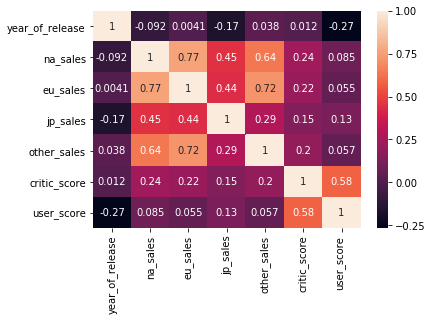

In [32]:
# матрица корреляции
sns.heatmap(data.corr(), annot=True);

# наибольшая корреляция из отсутствующих данных между critic_score и user_score.

Максимальная корреляция по столбцам с оценками критиков и пользователей. Столбца с возрастным рейтингом в таблице нет, т.к. он нечисловой, но по логике ясно, что в каждом рейтинге будут как игры с высокой пользовательской оценкой, так и с низкой и восстановить данные в столбцах с оценками по этим параметрам невозможно.

In [33]:
# дополнительно: просмотр поддиапазонов для корреляции
for i in range(0,100,10):
    corr_data_limited = data.query('critic_score >= @i and critic_score < '+str(i+10))
    print('Диапазон значений:{:.2f}-{:.2f}'.format(corr_data_limited['critic_score'].min(), corr_data_limited['critic_score'].max()))
    print('Корреляция: {:.2f}'.format(corr_data_limited['critic_score'].corr(corr_data_limited['user_score'])))
    print()

Диапазон значений:nan-nan
Корреляция: nan

Диапазон значений:13.00-19.00
Корреляция: 0.65

Диапазон значений:20.00-29.00
Корреляция: 0.22

Диапазон значений:30.00-39.00
Корреляция: 0.07

Диапазон значений:40.00-49.00
Корреляция: 0.11

Диапазон значений:50.00-59.00
Корреляция: 0.20

Диапазон значений:60.00-69.00
Корреляция: 0.14

Диапазон значений:70.00-79.00
Корреляция: 0.13

Диапазон значений:80.00-89.00
Корреляция: 0.11

Диапазон значений:90.00-98.00
Корреляция: 0.14



При разделении оценок на поддиапазоны картина уже не такая радужная. Высокая корреляция наблюдается только в районе очень низких оценок критиков, и насчёт этого пользователи с ними солидарны. Но нас эти низкие оценки не интересуют, интересны закономерности для высоких оценок, поэтому восстанавливать пропущенные значения в этом диапазоне нет смысла.

Сколько данных можно восстановить исходя из *возрастного рейтинга игры?* Для каждой игры он должен быть одинаковым для всех платформ.

In [34]:
# сохранение для проверки на ошибки
data['old_rating'] = data['rating']

In [35]:
# составление словаря для определения рейтинга игры исходя из названия и года выпуска (исключая ремейки)
games_rated_dict = (
    data
    .query('@pd.notna(rating)')
    .pivot_table(index=('name', 'year_of_release'), values='rating', aggfunc='first')
    .to_dict(orient='index')
)
games_rated_dict

{(' Tales of Xillia 2', 2012): {'rating': 'T'},
 ('.hack//Infection Part 1', 2002): {'rating': 'T'},
 ('.hack//Mutation Part 2', 2002): {'rating': 'T'},
 ('.hack//Outbreak Part 3', 2002): {'rating': 'T'},
 ('007 Racing', 2000): {'rating': 'T'},
 ('007: Quantum of Solace', 2008): {'rating': 'T'},
 ('007: The World is not Enough', 2000): {'rating': 'T'},
 ('1 vs. 100', 2008): {'rating': 'E'},
 ('10 Minute Solution', 2010): {'rating': 'E'},
 ('100 All-Time Favorites', 2009): {'rating': 'E'},
 ('1001 Touch Games', 2011): {'rating': 'E'},
 ('101-in-1 Explosive Megamix', 2008): {'rating': 'E'},
 ('101-in-1 Sports Megamix', 2010): {'rating': 'E10+'},
 ('101-in-1 Sports Party Megamix', 2010): {'rating': 'E10+'},
 ('1701 A.D.', 2006): {'rating': 'E10+'},
 ('18 Wheeler: American Pro Trucker', 2001): {'rating': 'E'},
 ('18 Wheeler: American Pro Trucker', 2002): {'rating': 'E'},
 ('18 Wheels of Steel: Extreme Trucker 2', 2011): {'rating': 'E'},
 ('187: Ride or Die', 2005): {'rating': 'M'},
 ('2002

In [36]:
# функция для заполнения рейтинга по строкам
def restore_rating(row):
    rating = row['rating']
    name = row['name']
    year = row['year_of_release']
    if pd.isna(rating):
        if (name, year) in games_rated_dict.keys():
            return games_rated_dict[(name, year)]['rating']
    return rating

In [37]:
data['rating'] = data.apply(restore_rating, axis=1)

In [38]:
# проверка, не удалились или заменились ли какие-либо значения
(
    data
    .query('@pd.notna(old_rating) and rating != old_rating')[['rating', 'old_rating']]
)
# всё ок

,rating,old_rating


In [ ]:
# проверка, есть ли игры с одинаковыми названиями и годами и разным рейтингом:
games_groups = (
    data
    .groupby(['name', 'year_of_release'])
)

print('Игры с различным рейтингом на разных платформах:')
for name, ddata in games_groups:
    if ddata.shape[0] > 1 and len(ddata['rating'].value_counts()) > 1:
        display(ddata[['name', 'platform', 'year_of_release', 'rating', 'old_rating']])

Игры с различным рейтингом на разных платформах:


,name,platform,year_of_release,rating,old_rating
10176,Astro Boy: The Video Game,PS2,2009,E10+,E10+
10305,Astro Boy: The Video Game,Wii,2009,E10+,E10+
10512,Astro Boy: The Video Game,DS,2009,E,E
13890,Astro Boy: The Video Game,PSP,2009,E10+,E10+


,name,platform,year_of_release,rating,old_rating
3949,Avatar: The Last Airbender,GC,2006,E10+,E10+
5454,Avatar: The Last Airbender,DS,2006,E,E
6232,Avatar: The Last Airbender,Wii,2006,E10+,E10+
10245,Avatar: The Last Airbender,PSP,2006,E10+,E10+


,name,platform,year_of_release,rating,old_rating
9965,Barnyard,GC,2006,E10+,E10+
10839,Barnyard,PS2,2006,E10+,E10+
13273,Barnyard,GBA,2006,E,E
13754,Barnyard,Wii,2006,E10+,E10+


,name,platform,year_of_release,rating,old_rating
3591,Batman Begins,PS2,2005,T,T
7433,Batman Begins,XB,2005,T,T
8313,Batman Begins,GBA,2005,E10+,E10+
8922,Batman Begins,GC,2005,T,T


,name,platform,year_of_release,rating,old_rating
5270,Batman: Rise of Sin Tzu,PS2,2003,T,T
10084,Batman: Rise of Sin Tzu,XB,2003,T,T
12193,Batman: Rise of Sin Tzu,GBA,2003,E,E
12517,Batman: Rise of Sin Tzu,GC,2003,T,T


,name,platform,year_of_release,rating,old_rating
3637,Batman: Vengeance,PS2,2001,T,T
6513,Batman: Vengeance,GC,2001,T,T
8102,Batman: Vengeance,GBA,2001,E,E


,name,platform,year_of_release,rating,old_rating
4442,Ben 10 Alien Force: Vilgax Attacks,Wii,2009,E10+,E10+
4568,Ben 10 Alien Force: Vilgax Attacks,DS,2009,E,E
4574,Ben 10 Alien Force: Vilgax Attacks,PSP,2009,E10+,E10+
5957,Ben 10 Alien Force: Vilgax Attacks,PS2,2009,E10+,E10+
7249,Ben 10 Alien Force: Vilgax Attacks,X360,2009,E10+,E10+


,name,platform,year_of_release,rating,old_rating
2176,Ben 10: Alien Force,DS,2008,E,E
2561,Ben 10: Alien Force,Wii,2008,E10+,E10+
3419,Ben 10: Alien Force,PSP,2008,E10+,E10+
3502,Ben 10: Alien Force,PS2,2008,E10+,E10+


,name,platform,year_of_release,rating,old_rating
10196,Bionicle Heroes,GC,2006,E10+,E10+
12089,Bionicle Heroes,X360,2006,E10+,E10+
12406,Bionicle Heroes,DS,2006,T,T


,name,platform,year_of_release,rating,old_rating
2473,Burnout Legends,PSP,2005,E10+,E10+
8154,Burnout Legends,DS,2005,E,E


,name,platform,year_of_release,rating,old_rating
70,Call of Duty 4: Modern Warfare,X360,2007,M,M
120,Call of Duty 4: Modern Warfare,PS3,2007,M,M
1772,Call of Duty 4: Modern Warfare,PC,2007,M,M
1964,Call of Duty 4: Modern Warfare,DS,2007,T,T


,name,platform,year_of_release,rating,old_rating
32,Call of Duty: Black Ops,X360,2010,M,M
41,Call of Duty: Black Ops,PS3,2010,M,M
1412,Call of Duty: Black Ops,Wii,2010,M,M
3439,Call of Duty: Black Ops,DS,2010,T,T


,name,platform,year_of_release,rating,old_rating
100,Call of Duty: World at War,X360,2008,M,M
170,Call of Duty: World at War,PS3,2008,M,M
887,Call of Duty: World at War,Wii,2008,M,M
2341,Call of Duty: World at War,DS,2008,T,T
8037,Call of Duty: World at War,PC,2008,M,M


Выбросы, или особенности конкретных игр, не связанные с преобразованием. Оценю результат восстановления значений.

In [ ]:
# было None, стало какое-то значение, в процентах
data.query('@pd.isna(old_rating) and @pd.notna(rating)').shape[0] * 100 / data.shape[0]

1.26% рейтингов восстановил.

#### Дополнительные метрики

In [ ]:
# подсчет суммарных продаж по каждой игре
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

**Вывод:**
Я проверил таблицу на артефакты, убедился, что дубли в названиях игр не являются ошибочными – у них различается платформа или год выпуска.

Обработал значения tbd в графе «Пользовательский рейтинг», приравняв к отсутствующим, т.к. это игры с низкой популярностью и для текущего исследования это одно и то же.

Отфильтровал данные от пропусков по годам, названиям игр, непопулярным рейтингам, отсутствующим полностью продажам - объем данных уменьшился менее чем на 2%.

Восстановление пропущенных значений критиков и пользователей по взаимной корреляции нецесообразно, т.к. высокая прямая корреляция наблюдается лишь у 2-х платформ из актуальных, а это менее 1.4% данных. Кроме того, на малых выборках данные могут шуметь больше, чем в целом.

Восстановил 1.3% данных о возрастном рейтинге игры, исходя из рейтинга аналогичных игр с тем же годом выпуска на других платформах. Мало, но зато точно.

### Шаг 3. Исследовательский анализ данных

Посмотрим распределения данных для каждого столбца:

In [ ]:
data

In [ ]:
# категориальные данные:
bar_columns=['platform', 'year_of_release', 'genre', 'rating']
def plot_bars(data):
#     рисуем барплоты по столбцам
    for column in bar_columns:
        stat = data.pivot_table(index=column, values='name', aggfunc='count')
        stat.columns = ['Count']
        if column == 'year_of_release':
#             не сортирую года
            stat = stat.reset_index()
        else:
            stat = stat.sort_values(by='Count', ascending=True).reset_index()
        stat.plot.bar(x=column, y='Count',figsize=(12,12))    
        plt.show()

In [ ]:
plot_bars(data) 

За все годы среди **выпускаемых** игр:

- PS2 и DS самые популярные платформы всех времён
- Наиболее "игровые" годы - 2008 и 2009
- Самый популярный жанр за все годы - Экшен
- Самый популярный рейтинг - E (Everyone) - для всех

До 1994 года игр выпускалось несопоставимо меньше, эти данные в дальнейшем не учитываю.

In [ ]:
# количественные данные (продажи, рейтинги критиков и пользователей):
def plot_hist(data):
    hist_columns = ['na_sales','eu_sales','jp_sales','other_sales','critic_score','user_score']
    for column in hist_columns:
        data.hist(column=column, bins=50)

In [ ]:
plot_hist(data)

In [ ]:
# Определю, выбросы ли в продажах или это самые продаваемые игры:
data.query('na_sales > 20 or eu_sales > 15 or jp_sales > 5 or other_sales > 5')

In [ ]:
# всё ок, это известные игры

In [ ]:
data.info()

In [ ]:
# Рейтинги критиков и пользователей выглядят правильными. Дополнительные характеристики распределения:
print(data['critic_score'].describe())
print()
print(data['user_score'].describe())

В центральных квартилях оценки критиков находятся в интервале от 60 до 80, пользователей - от 6.4 до 8.2.

#### Продажи по платформам:

In [ ]:
actual_platforms = (
    data
#     смотрим актуальные платформы на 2015 и 2016, т.к. за последний год данные неполные
    .query('year_of_release in [2015,2016]')
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .query('total_sales > 15')
    .index.tolist()
)
actual_platforms

In [ ]:
# отсеиваю старые платформы
data_actual = data.query('platform in @actual_platforms')

In [ ]:
main_platforms_stat = (data_actual
                       .pivot_table(index='year_of_release', columns='platform',
                                    values='total_sales', aggfunc='sum')
                      )
main_platforms_stat.plot(style='-o', figsize=(10,8),
                         title="Распределение продаж, млн. копий, на наиболее известных платформах по годам");

In [ ]:
# отфильтрую данные за годы ранее 2013, когда появились все актуальные платформы.
data_actual = (
    data_actual
    .query('year_of_release >= 2013')
)

Учитывая возможные неполные данные за 2016 год:
XOne, PS4 показывали до этого 2 года рост.
А PS3, 3DS и WiiU за этот же период показывали лишь убыль.
Следовательно, XOne и PS4 наиболее перспективные в будущем платформы.

##### Статистика средних продаж по платформам

In [ ]:
# сортировка платформ по медианам:
platform_stat_order = (
    data_actual
    .pivot_table(index='platform', values='total_sales', aggfunc='median')
    .sort_values(by='total_sales', ascending=False)
    .index.tolist()
)

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(y='platform', x='total_sales', data=data_actual, order=platform_stat_order);
plt.xlim(-0.1, 2)
plt.show()

Больше всего продаж в среднем у PS3, меньше всего - у 3DS. Остальные платформы (WiiU, XOne, PS4) находятся посередине и по продажам отличаются незначительно. Все медианы скошены влево, приблизительно одинаково, т.е. большей частью продажи невелики.
Наибольшие минимальные продажи PS3 - т.е. это наиболее стабильная по продажам платформа.
Малое количество "выбросов", а в данном случае явно выбивающихся по продажам игр у XOne и WiiU.

#### Посмотрю, как влияют на продажи по каждой платформе отзывы пользователей и критиков с помощью диаграмм рассеяния.

In [ ]:
# Платформа с наибольшим количеством оценок пользователей и критиков:
data_actual['score_count'] = data_actual.apply(lambda x: int(pd.notna(x['user_score'])) + int(pd.notna(x['critic_score'])), axis=1)

In [ ]:
# число - количество не-Null'ов из 2-х колонок. Идеально - 2
data_actual['score_count'].value_counts()
# можно восстановить максимум 13% данных

In [ ]:
# те же зависимости для остальных платформ:
strong_corr_dict = {}
weak_corr_dict = {}
for platform in data_actual['platform'].unique():
    data_platform = (
        data_actual
        .query('platform == @platform')
    )
    corr_platform = data_platform['critic_score'].corr(data_platform['user_score'])
    if corr_platform > 0.7:
        strong_corr_dict[platform] = corr_platform
    else:
        weak_corr_dict[platform] = corr_platform
    print('Платформа:', platform)
    print('Корреляция для оценок критиков и пользователей: {:.2f}'.format(corr_platform))
    try:
        g = sns.PairGrid(data_actual.query('platform == @platform')[['user_score', 'critic_score', 'total_sales']], height=4);
        g.map_diag(plt.hist)
        g.map_offdiag(plt.scatter, alpha=0.7)
        plt.show();
    except:
        print('Нет данных')

In [ ]:
print('Платформы с сильной корреляцией:')
for platform in strong_corr_dict:
    print('{: <5}: {:.2f}'.format(platform, strong_corr_dict[platform]))
print()
print('Платформы со слабой или средней корреляцией:')
for platform in weak_corr_dict:
    print('{: <5}: {:.2f}'.format(platform, weak_corr_dict[platform]))

Имеется средняя прямая корреляция между отзывами пользователей и критиков - 0.63.
Начиная с оценки критиков 90/100 количество продаж резко возрастает (отсутствуют низкие продажи). Такая же зависимость для оценок пользователей от 9/10.

#### Средние продажи по жанрам:

In [ ]:
# порядок сортировки
genres_stat_order = (
    data_actual
    .pivot_table(index='genre', values='total_sales', aggfunc='median')
    .sort_values(by='total_sales', ascending=False)
    .index.tolist()
)

In [ ]:
plt.figure(figsize=(15,15))
g = sns.boxplot(y="genre", x="total_sales", data=data_actual, order=genres_stat_order)
g.set(xlim=(0,2))
plt.show();

Шутеры - самый продаваемый жанр, явно вырывающийся вперёд и по медианному значению продаж, и по верхней границе межквартильного размаха.
Пазлы, стратегии и приключения, напротив, невыгодно отличаются по количеству продаж в меньшую сторону. У пазлов самая большая верхняя граница межквартильного размаха продаж, что говорит о более высоких продажах отдельных игр, нарушающих общий тренд.

#### Суммарные продажи по жанрам:

In [ ]:
genres_stat = (
    data_actual
    .pivot_table(index='genre', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=True)
    .reset_index()
)
genres_stat

In [ ]:
# график
f, ax = plt.subplots(figsize=(14, 10))
sns.barplot(x='genre', y='total_sales', data=genres_stat)
# plt.figure(figsize=(12,12))
plt.show();

Экшн - явный лидер с более 500 млн. проданных копий (по актуальным платформам), шутеры - твердое 2-е место с 348 млн. копий, а 3 уже делят спорт и ролевые игры (224 и 200 соответственно).

#### Суммарные продажи в зависимости от возрастного рейтинга

In [ ]:
rating_stat = (
    data_actual
    .pivot_table(index='rating', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=True)
    .reset_index()
)
rating_stat

In [ ]:
# график
f, ax = plt.subplots(figsize=(7, 10))
sns.barplot(x='rating', y='total_sales', data=rating_stat)
plt.show();

Рейтинг **Mature (для взрослых)** - явно лидирует с почти 600 млн. проданных копий.

**Выводы:**

За *все годы* среди **выпускаемых** игр:

PS2 и DS самые популярные платформы всех времён
Наиболее "игровые" годы - 2008 и 2009
Самый популярный жанр за все годы - Экшен
Самый популярный рейтинг - E (Everyone) - для всех
До 1994 года игр выпускалось несопоставимо меньше, эти данные в дальнейшем не учитываю.


***Платформы:***

Учитывая возможные неполные данные за 2016 год: XOne, PS4 показывали до этого 2 года рост. А PS3, 3DS и WiiU за этот же период показывали лишь убыль. Следовательно, **XOne** и **PS4** наиболее перспективные в будущем платформы.

Больше всего продаж в среднем у PS3, меньше всего - у 3DS. Остальные платформы (WiiU, XOne, PS4) находятся посередине и по продажам отличаются незначительно. Все медианы скошены влево, приблизительно одинаково, т.е. большей частью продажи невелики. Наибольшие минимальные продажи PS3 - т.е. это *наиболее стабильная по продажам* платформа. Малое количество "выбросов", а в данном случае явно выбивающихся по продажам игр у XOne и WiiU.

***Оценки***:

В центральных квартилях оценки критиков находятся в интервале от 60 до 80, пользователей - от 6.4 до 8.2.

Имеется средняя прямая корреляция между отзывами пользователей и критиков - 0.63. Начиная с оценки критиков 90/100 количество продаж резко возрастает (отсутствуют низкие продажи). Такая же зависимость для оценок пользователей от 9/10.

***По средним продажам (жанры):***

Шутеры - самый продаваемый жанр, явно вырывающийся вперёд и по медианному значению продаж, и по верхней границе межквартильного размаха. Пазлы, стратегии и приключения, напротив, невыгодно отличаются по количеству продаж в меньшую сторону. У пазлов самая большая верхняя граница межквартильного размаха продаж, что говорит о более высоких продажах отдельных игр, нарушающих общий тренд.

***По общим продажам (жанры):***

Экшн - явный лидер с более 500 млн. проданных копий (по актуальным платформам), шутеры - твердое 2-е место с 348 млн. копий, а 3 уже делят спорт и ролевые игры (224 и 200 соответственно).

***По общим продажам (рейтинг):***

Рейтинг **Mature (для взрослых)** - явно лидирует с почти 600 млн. проданных копий.

### Шаг 4. Составление портрета пользователя каждого региона

Учитывая тот факт, что продажи за разные годы значительно различались, перед сравнением буду нормировать данные как по региону, так и по годам.

##### Сравнение по платформам

In [ ]:
# Вычисление продаж по играм в зависимости от платформы и региона

# выбираю топ5 платформ по продажам за 2006-2016 для всех регионов по отдельности:
top5_platforms_total = []
for column in ['na_sales', 'eu_sales', 'jp_sales']:
    top5_platforms_region = (
        data_actual
        .pivot_table(index='platform', values=column, aggfunc='sum')
        .sort_values(by=column, ascending=False)
        .head(5).index.tolist()
    )
    for platform in top5_platforms_region:
        if platform not in top5_platforms_total:
            top5_platforms_total.append(platform)
top5_platforms_total

In [ ]:
# продажи до нормирования
stat_platforms = (
    data_actual
    .query('platform in @top5_platforms_total')        
    .pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
    .T
)
stat_platforms

In [ ]:
# нормирование данных
total_platforms = stat_platforms.sum(axis=1)
for column in stat_platforms.select_dtypes(include='number'):
    stat_platforms[column] = stat_platforms[column] / total_platforms
stat_platforms

In [ ]:
# проверка
stat_platforms.sum(axis=1)

In [ ]:
print('Сравнительная популярность платформ по регионам.')
for name, ddata in stat_platforms.iterrows(): 
    ddata.plot(kind='pie', figsize=(10,8),
                              title=name)
    plt.show()

Наиболее популярные платформы:
- PS3
- PS4
- XOne
- PS3
- WiiU

Лишь одна из них американская - XOne, остальные японские.

Популярность платформ в Северной Америке и Европе:
- PS3 занимает более половины рынка
- в Европе четверть рынка занимает PS4, на остальные 3 (XOne, 3DS, WiiU) приходится ещё четверть.
- в Северной Америке 3DS и XOne чуть более популярны и на PS4 остаётся где-то шестая часть рынка.

В Японии ситуация значительно отличается:
- Почти половину рынка занимает 3DS
- PS3 - треть
- оставшуюся приблизительно 1/6 делят PS4 и WiiU
- XOne практически не представлена (японцы поддерживают отечественного производителя!)

##### Сравнение по жанрам

In [ ]:
# вычисление популярных жанров для каждого региона:
top5_genres_total = []
for column in ['na_sales', 'eu_sales', 'jp_sales']:
    top5_genres_region = (
        data_actual
        .pivot_table(index='genre', values=column, aggfunc='sum')
        .sort_values(by=column, ascending=False)
        .head(5).index.tolist()
    )
    for genre in top5_genres_region:
        if genre not in top5_genres_total:
            top5_genres_total.append(genre)
top5_genres_total

In [ ]:
data_genres = data_actual.query('genre in @top5_genres_total')
# вычисление продаж по играм в зависимости от жанра и региона
stat_genres = (data_genres
              .pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
               .T
)

In [ ]:
# нормирование данных
total_genres = stat_genres.sum(axis=1)
for column in stat_genres.select_dtypes(include='number'):
    stat_genres[column] = stat_genres[column] / total_genres

In [ ]:
# проверка
stat_genres.sum(axis=1)

In [ ]:
print('Сравнительная популярность жанров по регионам')
for name, ddata in stat_genres.iterrows():
    ddata.plot(kind='pie', title=name, figsize=(8,8))
    plt.show()

В Северной Америке и Европе с явным отрывом идут *экшн и шутеры*, а далее по убыванию популярности:
- спорт
- ролевые игры
- гонки
- файтинг

В Японии *ролевые игры* выходят на первый план (очевидно, связано с культурными особенностями), потом идёт *экшн* и малое относительное число:
- шутеры
- симуляторы
- спорт
- файтинг
- гонки

##### Сравнение по возрастному рейтингу

In [ ]:
# вычисление продаж в зависимости от рейтинга и региона
stat_rating = (
    data_actual
    .pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
    .T
)

In [ ]:
rating_total = stat_rating.sum(axis=1)
rating_total

In [ ]:
# нормирование количества
for column in stat_rating.select_dtypes(include='number'):
    stat_rating[column] = stat_rating[column] / rating_total

In [ ]:
# проверка
stat_rating.sum(axis=1)

In [ ]:
print('Сравнительная популярность возрастных рейтингов по регионам:')
for name, ddata in stat_rating.iterrows():
    ddata.plot(kind='pie', title=name, figsize=(8,8))
    plt.show()

Как видно, игры для подростков (рейтинг T-'Teen') в Японии пользуются большей популярностью, нежели в других регионах, и кроме того, лишь в Японии их рейтинг выше игр для взрослых. Очевидно, это связано с культурой аниме, главными героями в которых, как правило, являются подростки.

**Выводы** по разделу "составление портрета пользователя каждого региона. Выводы легче делать в сравнении, поэтому я сравнил показатели:

***По платформам***:

Наиболее популярные платформы:
- PS3
- PS4
- XOne
- PS3
- WiiU

Лишь одна из них американская - XOne, остальные японские.

Популярность платформ в Северной Америке и Европе:
- PS3 занимает более половины рынка
- в Европе четверть рынка занимает PS4, на остальные 3 (XOne, 3DS, WiiU) приходится ещё четверть.
- в Северной Америке 3DS и XOne чуть более популярны и на PS4 остаётся где-то шестая часть рынка.

В Японии ситуация значительно отличается:
- Почти половину рынка занимает 3DS
- PS3 - треть
- оставшуюся приблизительно 1/6 делят PS4 и WiiU
- XOne практически не представлена (японцы поддерживают отечественного производителя!)

***По жанрам***:

В Северной Америке и Европе с явным отрывом идут *экшн и шутеры*, а далее по убыванию популярности:
- спорт
- ролевые игры
- гонки
- файтинг

В Японии *ролевые игры* выходят на первый план (очевидно, связано с культурными особенностями), потом идёт *экшн* и малое относительное число:
- шутеры
- симуляторы
- спорт
- файтинг
- гонки

***По возрастному рейтингу***:

Как видно, игры для подростков (рейтинг T-'Teen') в Японии пользуются большей популярностью, нежели в других регионах, и кроме того, лишь в Японии их рейтинг выше игр для взрослых. Очевидно, это связано с культурой аниме, главными героями в которых, как правило, являются подростки.

### Шаг 5. Проверка гипотез

#### Сравнительные рейтинги платформ

Рассмотрю гипотезы:

- H0 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- H1 - средние пользовательские рейтинги платформ Xbox One и PC различаются

In [ ]:
# составление выборок по платформам
Xbox_One_data = data.query('platform == "XOne"')
PC_data = data.query('platform == "PC"')

In [ ]:
print('Количество игр на платформе Xbox One:', Xbox_One_data.shape[0])
print('Количество игр на платформе PC:', PC_data.shape[0])

Т.к. значений в выборках больше 50-100, можно считать, что среднее  в этих выборках распределено нормально и можно применять t-критерий Стьюдента для проверки гипотезы.

In [ ]:
# вычисляю дисперсии
Xbox_One_var = np.var(Xbox_One_data['user_score'], ddof=1)
PC_var = np.var(PC_data['user_score'], ddof=1)
print('Дисперсия для платформы Xbox One: {:.2f}'.format(Xbox_One_var))
print('Дисперсия для платформы PC: {:.2f}'.format(PC_var))
print('Отношение: {:.2f}'.format(Xbox_One_var / PC_var))

Разница в 20%, считаем дисперсии разными.

In [ ]:
# т.к. данные распределены ненормально, примем стандартное значение alpha
alpha = 0.05

result = st.ttest_ind(Xbox_One_data.query('user_score.notna()')['user_score'],
                      PC_data.query('user_score.notna()')['user_score'], equal_var=False)
if (result.pvalue < alpha):
    print("P-value = {:.2f}. Отвергаем нулевую гипотезу".format(result.pvalue))
    PC_mean = PC_data['user_score'].mean()
    Xbox_One_mean = Xbox_One_data['user_score'].mean()
    print('Среднее значение пользовательского рейтинга для платформы PC: {:.2f}'.format(PC_mean))
    print('Среднее значение пользовательского рейтинга для платформы Xbox One: {:.2f}'.format(Xbox_One_mean))
    if PC_mean > Xbox_One_mean:
        print('Рейтинг PC выше')
    else:
        print('Рейтинг Xbox One выше')
else:
    print("P-value = {:.2f}. Не получилось отвергнуть нулевую гипотезу".format(result.pvalue))

Вывод: средний пользовательский рейтинг на платформе PC выше.

#### Сравнительные рейтинги жанров

- H0 - средние пользовательские рейтинги жанров Action и Sports одинаковые
- H1 - средние пользовательские рейтинги жанров Action и Sports различаются

In [ ]:
# выделим подтаблицы для выбранных жанров за актуальный период:
action_data = data_actual.query('genre == "Action"')
sports_data = data_actual.query('genre == "Sports"')

In [ ]:
print('Количество игр жанра Action:', action_data.shape[0])
print('Количество игр жанра Sports:', sports_data.shape[0])

Аналогично, считаю дисперсии:

In [ ]:
action_var = np.var(action_data['user_score'], ddof=1)
sports_var = np.var(sports_data['user_score'], ddof=1)
print('Дисперсия для игр жанра Action: {:.2f}'.format(action_var))
print('Дисперсия для игр жанра Sports: {:.2f}'.format(sports_var))
print('Отношение: {:.2f}'.format(action_var / sports_var))

In [ ]:
# разница в 38%, считаю дисперсии разными
# т.к. данные распределены ненормально, примем стандартное значение alpha для большей надежности
alpha = 0.05

result = st.ttest_ind(action_data.query('user_score.notna()')['user_score'],
                      sports_data.query('user_score.notna()')['user_score'], equal_var=False)
if (result.pvalue < alpha):
    print("P-value = {:.2f}. Отвергаем нулевую гипотезу".format(result.pvalue))
    action_mean = action_data['user_score'].mean()
    sports_mean = sports_data['user_score'].mean()
    print('Среднее значение пользовательского рейтинга для жанра "экшн": {:.2f}'.format(action_mean))
    print('Среднее значение пользовательского рейтинга для жанра "спорт": {:.2f}'.format(sports_mean))
    if action_mean > sports_mean:
        print('Рейтинг экшна выше')
    else:
        print('Рейтинг спорта выше')
else:
    print("P-value = {:.2f}. Не получилось отвергнуть нулевую гипотезу".format(result.pvalue))

**Выводы**:

В обоих случаях (для платформ *PC* и *Xbox One* и жанров *спорт* и *экшн*) целесообразно сравнение выборок на основании критерия Стьюдента.

Удалось отвергнуть нулевую гипотезу в случае сравнения платформ PC и XBox One, следовательно, среднее значение по количеству проданных для платформ игр достоверно различается.

Для жанров экшн и спорт также удалось отвергнуть нулевую гипотезу, достоверно более высокий средний пользовательский рейтинг показывает жанр экшн.

### Шаг 6. Общий вывод

**Ознакомление с данными:**

Пропуски в оценках пользователей, критиков и рейтинга (40-50%) - наибольшая проблема для достоверности анализа.

**Предобработка**:

Я проверил таблицу на артефакты, убедился, что дубли в названиях игр не являются ошибочными – у них различается платформа или год выпуска.

Обработал значения tbd в графе «Пользовательский рейтинг», приравняв к отсутствующим, т.к. это игры с низкой популярностью.

Отфильтровал данные от пропусков по годам, названиям игр, непопулярным рейтингам, отсутствующим полностью продажам - объем данных уменьшился менее чем на 2%.

Восстановление оценок критиков и пользователей, исходя из взаимной корреляции, нецелесообразно, т.к. высокая прямая корреляция наблюдается лишь у 2х актуальных платформ, это около 1,4% данных.

Восстановил данные пользовательского рейтинга для 1,26% данных, учитывая, что рейтинг игры с одним годом выхода на разных платформах одинаков.


**Исследовательский анализ данных**:

За ***все годы*** среди **выпускаемых** игр:

PS2 и DS самые популярные платформы всех времён
Наиболее "игровые" годы - 2008 и 2009
Самый популярный жанр за все годы - Экшен
Самый популярный рейтинг - E (Everyone) - для всех
До 1994 года игр выпускалось несопоставимо меньше, эти данные в дальнейшем не учитываю.

***Платформы:***

Учитывая возможные неполные данные за 2016 год: XOne, PS4 показывали до этого 2 года рост. А PS3, 3DS и WiiU за этот же период показывали лишь убыль. Следовательно, **XOne** и **PS4** наиболее перспективные в будущем платформы.

Больше всего продаж в среднем у PS3, меньше всего - у 3DS. Остальные платформы (WiiU, XOne, PS4) находятся посередине и по продажам отличаются незначительно. Все медианы скошены влево, приблизительно одинаково, т.е. большей частью продажи невелики. Наибольшие минимальные продажи PS3 - т.е. это *наиболее стабильная по продажам* платформа. Малое количество "выбросов", а в данном случае явно выбивающихся по продажам игр у XOne и WiiU.

***Оценки:***

В центральных квартилях оценки критиков находятся в интервале от 60 до 80, пользователей - от 6.4 до 8.2.

Имеется средняя прямая корреляция между отзывами пользователей и критиков - 0.63. Начиная с оценки критиков 90/100 количество продаж резко возрастает (отсутствуют низкие продажи). Такая же зависимость для оценок пользователей от 9/10.

***По средним продажам (жанры):***

Шутеры - самый продаваемый жанр, явно вырывающийся вперёд и по медианному значению продаж, и по верхней границе межквартильного размаха. Пазлы, стратегии и приключения, напротив, невыгодно отличаются по количеству продаж в меньшую сторону. У пазлов самая большая верхняя граница межквартильного размаха продаж, что говорит о более высоких продажах отдельных игр, нарушающих общий тренд.

***По общим продажам (жанры):***

Экшн - явный лидер с более 500 млн. проданных копий (по актуальным платформам), шутеры - твердое 2-е место с 348 млн. копий, а 3 уже делят спорт и ролевые игры (224 и 200 соответственно).

***По общим продажам (возрастной рейтинг):***

Рейтинг **Mature (для взрослых)** - явно лидирует с почти 600 млн. проданных копий.


**Портрет пользователя каждого региона:**

***По платформам***:

Наиболее популярные платформы:
- PS3
- PS4
- XOne
- PS3
- WiiU

Лишь одна из них американская - XOne, остальные японские.

Популярность платформ в Северной Америке и Европе:
- PS3 занимает более половины рынка
- в Европе четверть рынка занимает PS4, на остальные 3 (XOne, 3DS, WiiU) приходится ещё четверть.
- в Северной Америке 3DS и XOne чуть более популярны и на PS4 остаётся где-то шестая часть рынка.

В Японии ситуация значительно отличается:
- Почти половину рынка занимает 3DS
- PS3 - треть
- оставшуюся приблизительно 1/6 делят PS4 и WiiU
- XOne практически не представлена (японцы поддерживают отечественного производителя!)

***По жанрам***:

В Северной Америке и Европе с явным отрывом идут *экшн и шутеры*, а далее по убыванию популярности:
- спорт
- ролевые игры
- гонки
- файтинг

В Японии *ролевые игры* выходят на первый план (очевидно, связано с культурными особенностями), потом идёт *экшн* и малое относительное число:
- шутеры
- симуляторы
- спорт
- файтинг
- гонки

***По возрастному рейтингу***:

Как видно, игры для подростков (рейтинг T-'Teen') в Японии пользуются большей популярностью, нежели в других регионах, и кроме того, лишь в Японии их рейтинг выше игр для взрослых. Очевидно, это связано с культурой аниме, главными героями в которых, как правило, являются подростки.


**Проверка гипотез**:

В обоих случаях (для платформ *PC* и *Xbox One* и жанров *спорт* и *экшн*) целесообразно сравнение выборок на основании критерия Стьюдента.

Удалось отвергнуть нулевую гипотезу в случае сравнения платформ PC и XBox One, следовательно, среднее значение по количеству проданных для платформ игр достоверно различается.

Для жанров экшн и спорт также удалось отвергнуть нулевую гипотезу, достоверно более высокий средний пользовательский рейтинг показывает жанр экшн.

### **Итого, главные критерии успешности продаж игры:**

- Жанр - **экшн**.
- Рейтинг - **Mature (для взрослых)**
- Платформа: **Xbox One** или **PS4**